61 [0.0, 0.6492062, 1.4274136, 2.1423147, 3.284897, 4.482088, 6.2682343, 8.246716, 10.105428, 12.207826, 14.83699, 17.604752, 20.33733, 22.956675, 24.779959, 26.303314, 28.672272, 31.375504, 34.102825, 35.619125, 36.398045, 37.513596, 38.27818, 38.072067, 38.067192, 0.0, 0.78624326, 1.4337085, 2.539607, 3.7053628, 5.645016, 7.30464, 9.039363, 10.916402, 13.229271, 16.198122, 18.685684, 21.14041, 22.916157, 25.513355, 27.94784, 29.348795, 31.50086, 33.865555, 35.523033, 37.7508, 40.057705, 42.039772, 43.11012, 44.764027, 0.0, 0.75518674, 1.2807691, 2.0387385, 2.8837287, 4.136294, 5.289733, 6.6616454, 8.046556, 9.998761, 11.652825]
0 25 [0.0, 0.6492062, 1.4274136, 2.1423147, 3.284897, 4.482088, 6.2682343, 8.246716, 10.105428, 12.207826, 14.83699, 17.604752, 20.33733, 22.956675, 24.779959, 26.303314, 28.672272, 31.375504, 34.102825, 35.619125, 36.398045, 37.513596, 38.27818, 38.072067, 38.067192]
1 25 [0.0, 0.78624326, 1.4337085, 2.539607, 3.7053628, 5.645016, 7.30464, 9.039363, 10.916402

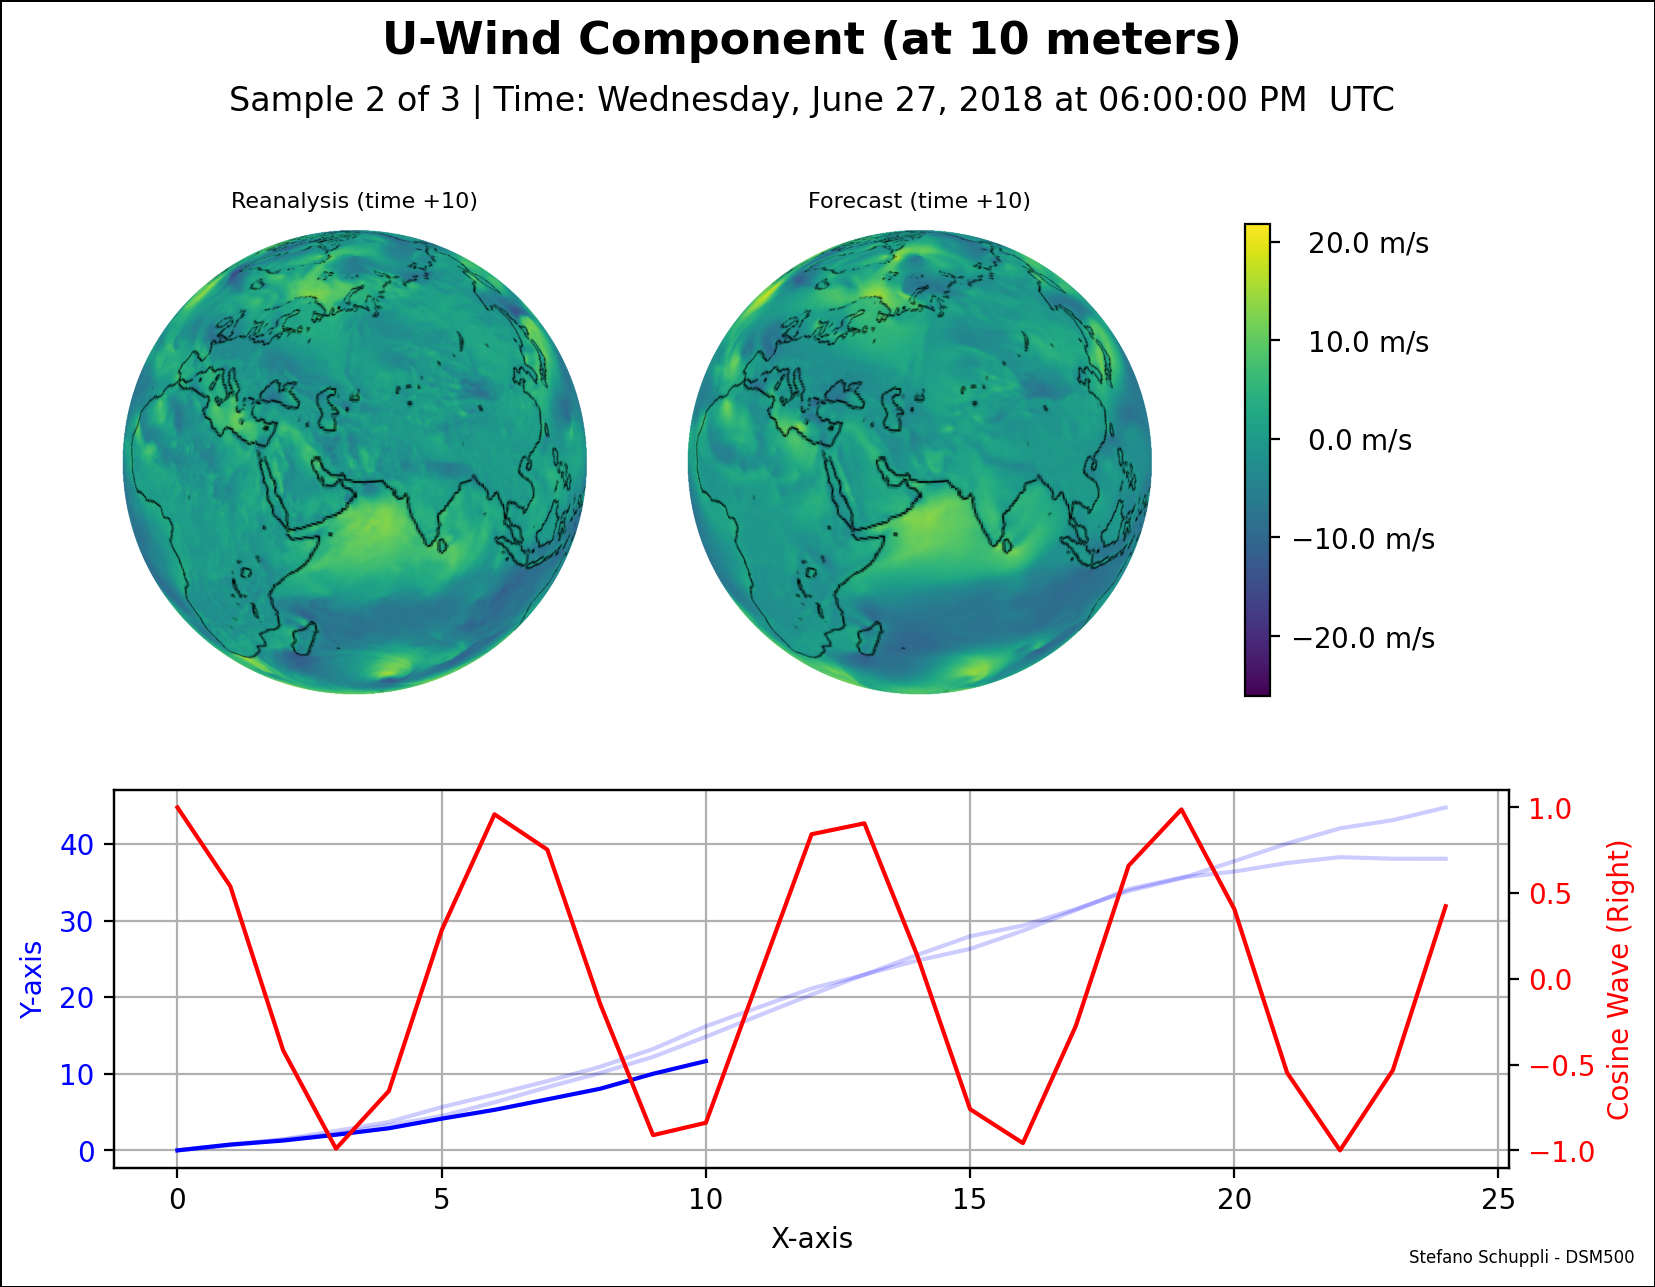

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import numpy as np
import h5py
import hydra
import json
from datetime import datetime


import sys
sys.path.append('/iopsstor/scratch/cscs/stefschu/DSM500/github/analysis/_inference')
from inference import Inference

from modulus.launch.logging import PythonLogger

from collections import defaultdict


class VideoFrameTwoGlobes:
    def __init__(
        self,
        dpi=200,
        crop=(105, 60, 60, 115) # l, r, t, b
    ):
        self.crop = crop
        self.dpi = dpi

        self.fig = plt.figure(figsize=(9, 8), dpi=self.dpi)
        self.fig.patch.set_edgecolor('black')
        self.fig.patch.set_linewidth(1)

        gs = GridSpec(
            4, 4,
            height_ratios=[0.2, 1, 0.8, 0.01],
            width_ratios=[0.94, 0.94, 0.05, 0.3],
            hspace=0.4, wspace=0.3
        )

        self.ax_title = self.fig.add_subplot(gs[0, :])
        self.ax_title.axis('off')

        self.ax_img_left = self.fig.add_subplot(gs[1, 0])
        self.ax_img_right = self.fig.add_subplot(gs[1, 1])
        self.ax_cbar = self.fig.add_subplot(gs[1, 2])

        self.ax_chart = self.fig.add_subplot(gs[2, :])

        self.ax_footer = self.fig.add_subplot(gs[3, :])
        self.ax_footer.axis('off')

    def crop_image(self, image):
        l, r, t, b = self.crop
        h, w, _ = image.shape
        return image[t:h-b, l:w-r]

    def title(self, title, subtitle):
        self.ax_title.text(0.5, 0.8, 
            title,
            fontsize=16, 
            fontweight='bold',
            ha='center',
            transform=self.ax_title.transAxes
        )
        self.ax_title.text(0.5, 0.2, 
            subtitle,
            fontsize=12, 
            ha='center',
            transform=self.ax_title.transAxes
        )
        return self

    def footer(self, text):
        self.ax_footer.text(1, 0.0, 
            text,
            fontsize=6,
            ha='right',
            va='bottom',
            transform=self.ax_footer.transAxes,
            position=(1.09, 0)
        )
        return self

    def _img(self, ax, title, file_path):
        img = mpimg.imread(file_path)
        img = self.crop_image(img)

        ax.set_title(title, fontsize=8)
        ax.imshow(img, aspect='equal')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')
        return self

    def img_left(self, title, file_path):
        self._img(self.ax_img_left, title, file_path)
        return self

    def img_right(self, title, file_path):
        self._img(self.ax_img_right, title, file_path)
        return self

    def cbar(self, vmin, vmax, ticks_format):
        def formatter(x, _):
            number, unit = ticks_format.split(" ")
            string = number.format(x).replace(",", "'")
            string = f"${string} \\ \\mathrm{{{unit}}}$"
            if x >= 0:
                string = "  " + string
            return string
        cbar = self.fig.colorbar(cm.ScalarMappable(
            norm=plt.Normalize(vmin, vmax),
            cmap=plt.get_cmap("viridis")
        ), cax=self.ax_cbar)
        cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(formatter))
        return self

    def chart(self, x, y_left, y_right, x_label, y_left_label, y_right_label):
        for i in range(len(y_left)-1):
            self.ax_chart.plot(x, y_left[i], color='blue', alpha=0.3)
        self.ax_chart.plot(x, y_left[-1], color='blue')

        self.ax_chart.set_xlabel(x_label)
        self.ax_chart.set_ylabel(y_left_label, color='blue')
        self.ax_chart.tick_params(axis='y', labelcolor='blue')
        self.ax_chart.grid(True)

        ax_right = self.ax_chart.twinx()
        ax_right.plot(x, y_right, color='red')
        ax_right.set_ylabel(y_right_label, color='red')
        ax_right.tick_params(axis='y', labelcolor='red')
        return self

    def savefig(self, output_file_path):
        plt.savefig(output_file_path, dpi=self.dpi, bbox_inches='tight', pad_inches=0.3)

    def show(self):
        plt.show()
        plt.close(self.fig)

class ChartsAccumulator:
    def __init__(
        self,
        rollout_steps,
        samples
    ):
        self.rollout_steps = rollout_steps
        self.samples = samples
        self.mse = list()

    def reset(self):
        self.mse = list()

    def record(self, reanalysis, forecast):
        if len(self.mse) == (self.rollout_steps + 1) * self.samples:
            self.reset()
        
        self.mse.append(np.square(reanalysis - forecast).mean())

    @property
    def x(self):
        return list(range(self.rollout_steps + 1))

    @property
    def y_left(self):
        print(len(self.mse), self.mse)
        # Split list
        rollouts = list()
        current_rollout = list()
        for mse in self.mse:
            current_rollout.append(mse)
            if len(current_rollout) == self.rollout_steps + 1:
                rollouts.append(current_rollout)
                current_rollout = list()
        rollouts.append(current_rollout)

        # Pad last rollout
        rollouts[-1].extend([None] * (self.rollout_steps + 1 - len(rollouts[-1])))
        for i in range(len(rollouts)):
            print(i, len(rollouts[i]), rollouts[i])
        
        return rollouts

    @property
    def y_right(self):
        return np.cos(self.x)

import os

os.environ["SLURM_PROCID"] = "0"
os.environ["SLURM_NTASKS"] = "1"

import hydra
with hydra.initialize(config_path="..", version_base="1.3"):
    cfg = hydra.compose(config_name="config_new")

logger = PythonLogger("main")
logger.file_logging()

inference = Inference(cfg, logger)

# Load plan, and select activities for this rank
with open(inference.plan_file_path, "r") as f:
    plan = json.load(f)
# Filter out pause frames which do not need to be rendered
activities = [a for a in plan if a["type"] != "pause"]

acc = ChartsAccumulator(
    rollout_steps=cfg.inference.rollout_steps,
    samples=cfg.inference.samples
)

with h5py.File(inference.container_file_path, "r") as f:
    for activity_i, activity in enumerate(activities):
        output_file_path = inference.images_dir / f"frame_{activity['frame_id']}.png"

        sample = activity["sample"]
        step = activity["step"] if "step" in activity else 0
        channel = activity["channel"]

        timestamp = datetime.fromtimestamp(activity["timestamp"])
        time_string = timestamp.strftime("%A, %B %d, %Y at %I:%M:%S %p %Z UTC")

        title = inference.get_channel_title(activity["channel"])
        subtitle = f"Sample {sample} of {cfg.inference.samples} | Time: {time_string}"


        if activity["type"] == "ic":
            input_file_path_left = input_file_path_right = inference.images_dir / activity["filename"]
            title_left = title_right = "Initial Condition (time 0)"
            acc.record(f["ic"][sample][step][channel], f["ic"][sample][step][channel])
        else:
            input_file_path_left = inference.images_dir / activity["filename"]["reanalysis"]
            input_file_path_right = inference.images_dir / activity["filename"]["forecast"]
            title_left = f"Reanalysis (time +{step+1})"
            title_right = f"Forecast (time +{step+1})"
            acc.record(f["reanalysis"][sample][step][channel], f["forecast"][sample][step][channel])


        if activity_i == 60:
            VideoFrameTwoGlobes()\
            .title(title, subtitle)\
            .img_left(title_left, input_file_path_left)\
            .img_right(title_right, input_file_path_right)\
            .cbar(activity["vmin"], activity["vmax"], inference.get_channel_tick_format(activity["channel"]))\
            .chart(acc.x, acc.y_left, acc.y_right, "X-axis", "Y-axis", "Cosine Wave (Right)")\
            .footer("Stefano Schuppli - DSM500")\
            .show()
            #.savefig(output_file_path)
            break

        

In [71]:
None * 10

TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'